# 8 schools data

In [1]:
from numpyro.infer import Predictive
from numpyro.infer.reparam import TransformReparam, LocScaleReparam
from jax import random
import numpyro.distributions as dist
import numpyro
import numpy as np
import matplotlib.pyplot as plt

from numpyro.infer import Alternator, Hug, Hop, MCMC

Let us explore NumPyro using a simple example. We will use the eight schools example from Gelman et al., Bayesian Data Analysis: Sec. 5.5, 2003, which studies the effect of coaching on SAT performance in eight schools.

The data is given by:

In [2]:
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

where `y` are the treatment effects and `sigma` the standard error. 

We build a hierarchical model for the study where we assume that the group-level parameters `theta` for each school are sampled from a Normal distribution with unknown mean `mu` and standard deviation `tau`, while the observed data are in turn generated from a Normal distribution with mean and standard deviation given by `theta` (true effect) and `sigma`, respectively. 
This allows us to estimate the population-level parameters `mu` and `tau` by pooling from all the observations, while still allowing for individual variation amongst the schools using the group-level `theta` parameters.
This is written in `numpyro` using:

In [3]:
def eight_schools(J, sigma, y=None):
    mu = numpyro.sample('mu', dist.Normal(0, 5))
    tau = numpyro.sample('tau', dist.HalfCauchy(5))
    with numpyro.plate('J', J):
        theta = numpyro.sample('theta', dist.Normal(mu, tau))
        numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)

Let us infer the values of the unknown parameters in our model by running MCMC using the No-U-Turn Sampler (NUTS). Note the usage of the extra_fields argument in MCMC.run. By default, we only collect samples from the target (posterior) distribution when we run inference using MCMC. However, collecting additional fields like potential energy or the acceptance probability of a sample can be easily achieved by using the extra_fields argument. For a list of possible fields that can be collected, see the `HMCState` object. In this example, we will additionally collect the `potential_energy` for each sample.

In [25]:
hug = Hug(eight_schools, step_size=0.1, trajectory_length=10)
hop = Hop(eight_schools, lam=0.5, mu=0.01)
kernel = Alternator(hug, hop)

mcmc = MCMC(kernel, num_warmup=0, num_samples=1000, num_chains=1)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, J, sigma, y=y, extra_fields=('potential_energy','accept_prob'))
mcmc.print_summary()

  0%|          | 0/1000 [00:00<?, ?it/s]

initializing init_params for hop


sample: 100%|██████████| 1000/1000 [01:36<00:00, 10.31it/s]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      4.20      3.58      4.26     -1.26     10.56    559.40      1.00
       tau      1.53      0.51      1.58      0.78      2.40      3.64      1.75
  theta[0]      7.12      5.98      7.02     -2.28     17.78    565.52      1.09
  theta[1]      5.18      6.03      4.81     -5.34     14.50    675.81      1.01
  theta[2]      3.74      6.24      4.04     -5.94     13.96    633.83      1.01
  theta[3]      4.88      5.10      4.88     -3.13     13.53    648.79      1.00
  theta[4]      2.95      5.38      2.89     -6.18     11.56    645.12      1.01
  theta[5]      3.72      5.95      3.89     -6.46     11.91    667.44      1.01
  theta[6]      7.35      5.67      7.12     -1.18     17.07    620.90      1.08
  theta[7]      4.91      6.43      5.02     -5.36     15.73    659.37      1.00



In [15]:
pe = mcmc.get_extra_fields()['potential_energy']
print('Expected log joint density: {:.2f}'.format(np.mean(-pe)))

Expected log joint density: -53.44


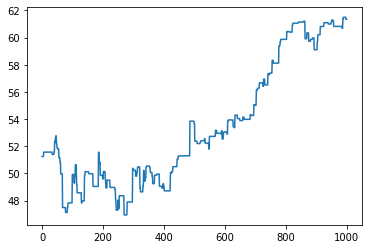

In [16]:
plt.plot(pe)

In [19]:
ap = mcmc.get_extra_fields()['accept_prob']
ap_hug = ap[0::2]
ap_hop = ap[1::2]

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 500.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

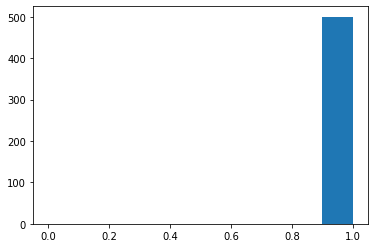

In [22]:
plt.hist(ap_hug, range=(0,1))

(array([300.,  21.,  16.,  10.,   9.,  14.,  13.,  18.,  12.,  87.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

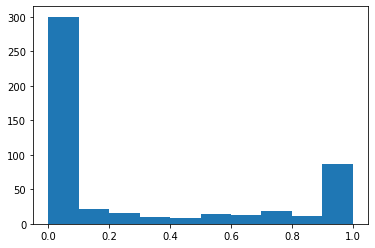

In [24]:
plt.hist(ap_hop, range=(0,1))

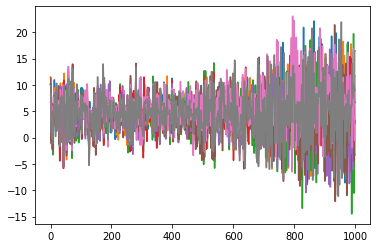

In [12]:
samples = mcmc.get_samples()
plt.plot(samples['theta'])

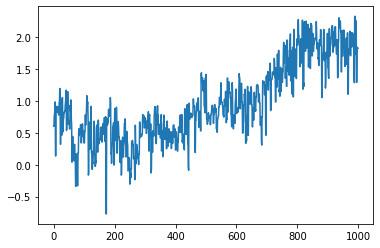

In [13]:
plt.plot(samples['tau'])

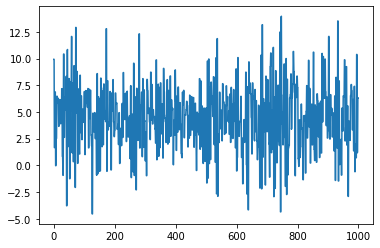

In [14]:
plt.plot(samples['mu'])

The values above 1 for the split Gelman Rubin diagnostic `r_hat` indicates that the chain has not fully converged. The low value for the effective sample size `n_eff`, particularly for `tau`, and the number of divergent transitions looks problematic. 
Fortunately, this is a common pathology that can be rectified by using a non-centered paramaterization for `tau` in our model. This is straightforward to do in `numpyro` by using a `TransformedDistribution` instance together with a "reparameterization effect handler". Let us rewrite the same model but instead of sampling `theta` from a Normal(`mu`, `tau`), we will instead sample it from a base Normal(0, 1) distribution that is transformed using an `AffineTransform`. 
Note that by doing so, `nunmpyro` runs HMC by generating samples `theta_base` for the base Normal(0, 1) distribution instead. We see that the resulting chain does not suffer from the same pathology — the Gelman Rubin diagnostic is 1 for all the parameters and the effective sample size looks quite good!

In [35]:
def eight_schools_noncentered(J, sigma, y=None):
    mu = numpyro.sample('mu', dist.Normal(0, 5))
    tau = numpyro.sample('tau', dist.HalfCauchy(5))
    with numpyro.plate('J', J):
        with numpyro.handlers.reparam(config={'theta': TransformReparam()}):
            theta = numpyro.sample(
                'theta',
                dist.TransformedDistribution(dist.Normal(0., 1.),
                                             dist.transforms.AffineTransform(mu, tau)))
        numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)


hug = Hug(eight_schools_noncentered, step_size=0.1, trajectory_length=1)
hop = Hop(eight_schools_noncentered, lam=2, mu=1)
kernel = Alternator(hug, hop)
mcmc = MCMC(kernel, num_warmup=0, num_samples=1000)

rng_key = random.PRNGKey(0)
mcmc.run(rng_key, J, sigma, y=y, extra_fields=('potential_energy',))
mcmc.print_summary(exclude_deterministic=False)
pe = mcmc.get_extra_fields()['potential_energy']
print('Expected log joint density: {:.2f}'.format(np.mean(-pe)))

sample: 100%|██████████| 1000/1000 [00:03<00:00, 310.32it/s]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
           mu      4.43      3.47      4.71     -0.89     10.17     46.47      1.00
          tau      1.00      1.05      1.15     -0.58      2.60    272.01      1.00
theta_base[0]      0.40      0.93      0.43     -1.13      1.96    568.64      1.00
theta_base[1]      0.14      0.90      0.12     -1.38      1.57    592.16      1.00
theta_base[2]     -0.12      1.00     -0.10     -1.72      1.40    578.15      1.00
theta_base[3]      0.08      0.85      0.03     -1.34      1.40    602.75      1.00
theta_base[4]     -0.15      0.87     -0.18     -1.52      1.33    613.06      1.00
theta_base[5]     -0.09      0.87     -0.05     -1.56      1.31    574.61      1.00
theta_base[6]      0.37      0.92      0.38     -0.98      2.19    560.46      1.00
theta_base[7]      0.07      0.92      0.10     -1.57      1.46    574.82      1.00

Expected log joint density: -45.75


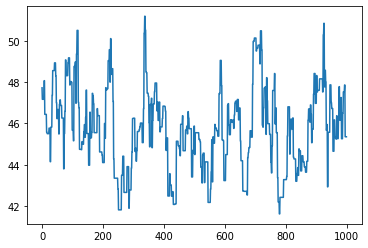

In [36]:
plt.plot(pe)

In [24]:
samples = mcmc.get_samples()
plt.plot(samples['theta'])

KeyError: 'theta'

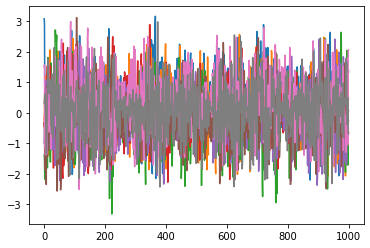

In [25]:
plt.plot(samples['theta_base'])

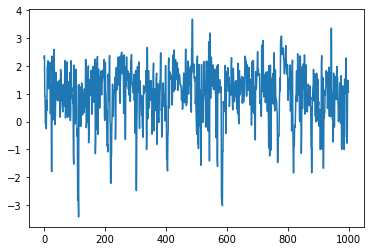

In [26]:
plt.plot(samples['tau'])

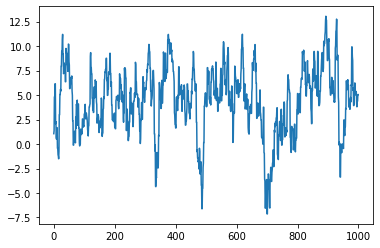

In [27]:
plt.plot(samples['mu'])

Now, assume that we have a new school for which we have not observed any test scores, but we would like to generate predictions. `numpyro` provides a `Predictive` class for such a purpose. Note that in the absence of any observed data, we simply use the population-level parameters to generate predictions. The `Predictive` utility conditions the unobserved `mu` and `tau` sites to values drawn from the posterior distribution from our last MCMC run, and runs the model forward to generate predictions.

In [28]:
def new_school():
    mu = numpyro.sample('mu', dist.Normal(0, 5))
    tau = numpyro.sample('tau', dist.HalfCauchy(5))
    return numpyro.sample('obs', dist.Normal(mu, tau))

predictive = Predictive(new_school, mcmc.get_samples())
samples_predictive = predictive(random.PRNGKey(1))
print(np.mean(samples_predictive['obs']))  

4.4819393
